# Hotel bookings dataset found [here](https://www.kaggle.com/jessemostipak/hotel-booking-demand). Original publication found [here](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

## Background

Looking at the original publication, we get a lot of good information about the origin of the data. The data is taken from the Property Management System (PMS) of two hotels located in Portugal. One is "at the resort region of Algarve" while the other is is Lisbon. The data included is for dates ranging from the 1st of July of 2015 and the 31st of August 2017. More detailed information can be found in the above link.

I will do the following:
- Perform some EDA
- Explore a few ML models to predict if the guest will cancel and if they will require special requests

#### EDA
I will dig into the data for answers to the following questions:
1. Where are the guests from?
2. Which months are busiest/slowest?
3. How does price change over the year?
4. Are there any different trends between the resort hotel and the city hotel? How do the guests from each differ (kids, planning, breakfast, etc.)?
5. Are there differences between the guests that brought kids and the guests that did not?
6. If they cancelled:
    - Who did?
    - How many did?
    - Are there any trends in cancellations?

#### Prediction
Once I am comfortable that I have a grasp on the data and some relationships that may be present, I will create a few different ML models and compare their results. I am going to attempt to predict two different things. The first is the most obvious; will a given guest cancel their booking? The second is something else that I think would be of interest; will a given guest require special requests. I believe both of these things would be useful to predict.

## Exploratory Data Analysis (EDA)
First I am going to need to preprocess some of the data, looking for null values, outliers, missing data, etc. Then I will begin to create charts to answer some of the questions above.

#### Preprocessing
The first thing I want to do is take a quick glance at the data. The dtale library is great for this and allows me to see a quick summary of any column that I want.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import dtale as dt
from datetime import datetime
from _plotly_future_ import v4_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.graph_objs as go
%matplotlib inline
init_notebook_mode(connected=True)

In [2]:
hotel_df = pd.read_csv('Data\hotel_bookings.csv\hotel_bookings.csv')

In [3]:
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
dt.show(hotel_df)

I noticed there are some missing values in a few columns. I also noticed some issues with some of the rows, such as a negative adr value and some rows that have 0 people. I will simply remove these since there are not many of them.

In [5]:
hotel_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Publication states that if agent is NA then there likely wasn't an agent used to book
# Also, replacing meals values of 'Undefined' with 'SC' since they are the same
hotel_df['children'].fillna(0)
hotel_df['country'].fillna('Unknown')
hotel_df['agent'].fillna(0)
hotel_df['company'].fillna(0)
hotel_df['meal'].replace('Undefined','SC', inplace=True)

# Removing values
hotel_df.drop(hotel_df[hotel_df['adr'] < 0].index, inplace=True)
hotel_df.drop(hotel_df[hotel_df['adults'] + hotel_df['children'] + hotel_df['babies'] == 0].index, inplace=True)

## Visualizations
Now we are ready to look at some visualizations. For this analysis I am only interested in looking at people who actually showed up (did NOT cancel). Later on we will look at who cancelled and the differences between who did and who didn't.

In [7]:
hotel_df_nc = hotel_df[hotel_df['is_canceled'] == 0]

#### Where are the guests from?

Text(0, 0.5, '')

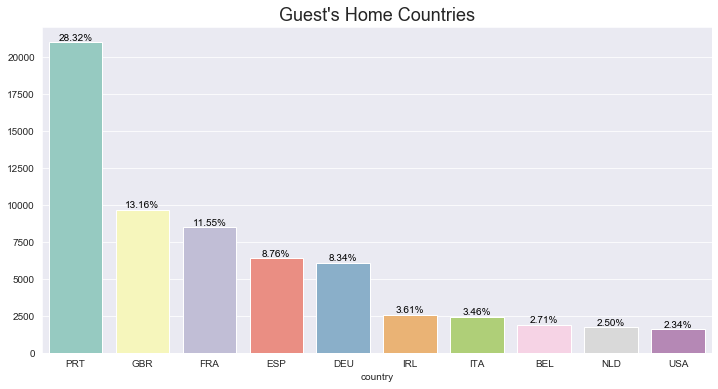

In [8]:
hotel_df_country = pd.DataFrame(hotel_df_nc.groupby('country').count().iloc[:,0].sort_values(ascending = False))

sns.set_style(style="darkgrid")
plt.figure(figsize=(12,6))
g = sns.barplot(data = hotel_df_country.head(10), x = hotel_df_country.head(10).index,
                y = list(hotel_df_country.iloc[:10,0].values), palette='Set3')

# Add % to top
for p in g.patches:
    height = p.get_height() + 150
    g.text(p.get_x() + p.get_width()/2., height,'{:.2%}'.format(height/hotel_df_country.iloc[:,0].sum()),
           ha = "center", color='black')

plt.title("Guest's Home Countries", fontsize = 18)
g.set_ylabel('')

In [9]:
data = dict(type = 'choropleth',
            colorscale = 'Cividis',
            locations = hotel_df_country.index,
            z = list(hotel_df_country.iloc[:,0].values),
            colorbar = {'title':'# of Hotel Visitors'}
            )

layout = dict(title = "Hotel Visitor's Home Country")

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap)

So, unsurprisingly, the country with the most guests that visit this hotel is Portugal followed by a slew of other nearby European countries.

#### Which months are busiest/slowest?
It is important to remember the date ranges for this data. If we leave it as is, July and August will be counted 3 times whereas every other month will only be counted twice. To fix this, I will exclude July & August of 2015 from all of these date visualizations.

In [10]:
# Add full date column
hotel_df_date = hotel_df[['arrival_date_year','arrival_date_month','arrival_date_day_of_month']]
hotel_df_date['arrival_date_month'] = [datetime.strptime(x,'%B').month for x in hotel_df_date['arrival_date_month']]
hotel_df_date.columns = ['year','month','day']
hotel_df['arrival_date'] = pd.to_datetime(hotel_df_date)

hotel_df['has_kids'] = [int(a) for a in (hotel_df['children'] + hotel_df['babies']) > 0]
hotel_df['is_summer'] = [s in(['June','July','August']) for s in hotel_df['arrival_date_month']]

# Excludes dates mentioned above
hotel_df_dates = hotel_df[~((hotel_df['arrival_date_year'] == 2015) &
                            (hotel_df['arrival_date_month'].isin(['July','August'])) |
                            (hotel_df['is_canceled'] == 1))]

# month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
hotel_df_dates = hotel_df_dates.groupby(['arrival_date_month','hotel']).count()/2
hotel_df_dates.reset_index(inplace = True)
hotel_df_dates['month_num'] = [datetime.strptime(x, '%B').month for x in hotel_df_dates['arrival_date_month']]
hotel_df_dates.sort_values(by = 'month_num', inplace = True)

city_hotel_df = hotel_df_dates[hotel_df_dates['hotel'] == 'City Hotel']
resort_hotel_df = hotel_df_dates[hotel_df_dates['hotel'] == 'Resort Hotel']

In [12]:
g = go.Figure()
g.add_trace(go.Scatter(x=city_hotel_df['arrival_date_month'],y=city_hotel_df['is_canceled'],name='City Hotel',
                       line = dict(color='goldenrod')))
g.add_trace(go.Scatter(x=resort_hotel_df['arrival_date_month'],y=resort_hotel_df['is_canceled'], name='Resort Hotel',
                       line = dict(color='firebrick')))
g.layout.update(title = 'Average Hotel Guests by Month', yaxis_title = '# of Guests')
g.show()

For both hotels we see that winter is the slow season. For the city hotel the number of guests between March - October is fairly constant, staying within the 2000 - 2200 range with the exception of May. The resort hotel, aside from the spike in October, seems to be more popular during the spring months. This was a surprise to me, as I thought summer would be the most popular for a resort hotel.

#### How does price change over the year?
There is no explicit definition of what the currency is based in. Based on [this](https://lisbonguide.org/currency-in-portugal/), we will assume that everything is in EUR.

In [13]:
hotel_df_prices = hotel_df[~((hotel_df['arrival_date_year'] == 2015) &
                            (hotel_df['arrival_date_month'].isin(['July','August'])) |
                            (hotel_df['is_canceled'] == 1))]

In [14]:
hotel_df_prices = hotel_df_prices.groupby(['arrival_date_month','hotel'], as_index=False).mean()
# hotel_df_prices.reset_index(drop = True, inplace = True)
hotel_df_prices['month_num'] = [datetime.strptime(x, '%B').month for x in hotel_df_prices['arrival_date_month']]
hotel_df_prices.sort_values(by = 'month_num', inplace = True)

city_hotel_prices_df = hotel_df_prices[hotel_df_prices['hotel'] == 'City Hotel']
resort_hotel_prices_df = hotel_df_prices[hotel_df_prices['hotel'] == 'Resort Hotel']

In [15]:
g = go.Figure()
g.add_trace(go.Scatter(x=city_hotel_prices_df['arrival_date_month'],y=city_hotel_prices_df['adr'],name='City Hotel',
                       line = dict(color='goldenrod')))
g.add_trace(go.Scatter(x=resort_hotel_prices_df['arrival_date_month'],y=resort_hotel_prices_df['adr'],name='Resort Hotel',
                       line = dict(color='firebrick')))
g.layout.update(title = 'Average Daily Rate (ADR) by Month', yaxis_title = 'ADR (EUR)')
g.show()

We see that the price trend for the city hotel more or less follows the trend of the number of guests, with winter months being less expensive. However, for the resort hotel we see a huge price increase during the summer months. I would expect this, but I would also expect the price increase to be met with high demand. The data does not support this. Perhaps the high prices are driving potential guests elsewhere.

#### Are there any different trends between the resort hotel and the city hotel? How do the guests from each differ (kids, planning, breakfast, etc.)?
We have already looked at some of the trends related to time. Now we will explore other differences between the resort hotel and city hotel that are not necessarily related to the time of year.

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Days Booked in Advance')

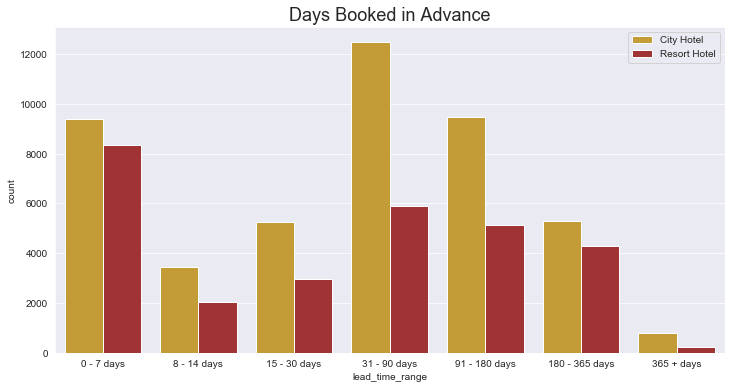

In [16]:
# Saving FSU colors for future use
fsu_colors = ['#daa520','#b22222']
hue_order=['City Hotel','Resort Hotel']
hotel_df_nc['lead_time_range'] = pd.cut(hotel_df_nc['lead_time'], [-np.inf,7,14,30,90,180,365,np.inf])


plt.figure(figsize=(12,6))
g = sns.countplot(data = hotel_df_nc, x = 'lead_time_range', hue='hotel', hue_order=hue_order, palette=fsu_colors)
g.set(xticklabels = ['0 - 7 days','8 - 14 days','15 - 30 days','31 - 90 days','91 - 180 days','180 - 365 days','365 + days'])
g.legend(title = '')
plt.title('Days Booked in Advance', fontsize = 18)

There seem to be 2 main groups of people; one that plans ahead of time (31 days or more) and another that waits until within a week to book. For the city hotel, booking at least 31 days in advance is the favorite. However, for the resort hotel, booking within the final week is the most common method.

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Total Length of Stay (Days)')

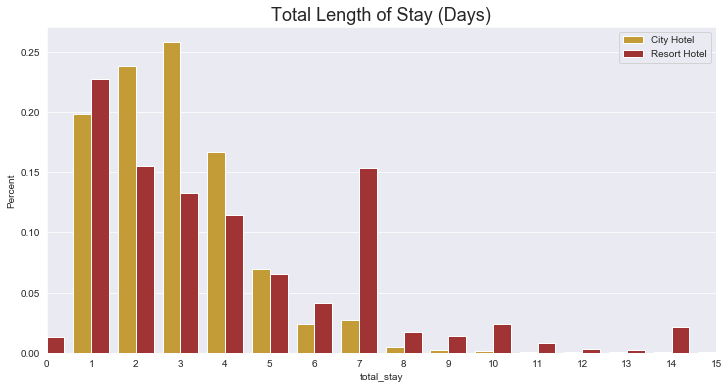

In [17]:
hotel_df_nc['total_stay'] = hotel_df_nc['stays_in_week_nights'] + hotel_df_nc['stays_in_weekend_nights']
hotel_df_nc_pct = hotel_df_nc['total_stay'].groupby(hotel_df_nc['hotel']).value_counts(normalize=True).rename('Percent').reset_index()

plt.figure(figsize=(12,6))
g = sns.barplot(x='total_stay', y='Percent', data=hotel_df_nc_pct, hue='hotel', palette=fsu_colors, hue_order=hue_order)
g.legend(loc='upper right')
plt.xlim(0,15)
plt.title('Total Length of Stay (Days)', fontsize = 18)

For the city hotel we see that over 80% of the guests stay for a total of 4 nights or less. For the resort hotel there is a sizeable amount (~15%) of guests that stay for 7 nights. Sometimes resort hotels require this for certain discount packages, so perhaps this is why we see the spike.

In [18]:
def group_kids(x):
    
    if x[0] + x[1] == 0:
        return('None')
    elif x[0] + x[1] == 1:
        return('One')
    elif x[0] + x[1] > 1:
        return('Two or More')

In [19]:
hotel_df_nc['kid_group'] = hotel_df_nc[['children','babies']].apply(group_kids, axis = 1)
hotel_df_kid = hotel_df_nc.groupby(['hotel','kid_group'])['is_canceled'].count()
hotel_df_kid = hotel_df_kid.groupby(level = 0).apply(lambda x: 100 * x/float(x.sum()))

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
g = make_subplots(rows=1, cols=2, subplot_titles = ('City Hotel','Resort Hotel'), specs=[[{"type": "pie"}, {"type": "pie"}]])

labels = list(hotel_df_kid.index.get_level_values(1).unique())
sizes = list(hotel_df_kid.loc[('City Hotel',)])

g.add_trace(
    go.Pie(labels=labels, hoverinfo='label+percent', values=sizes, textposition='outside', rotation=90, name = 'City Hotel'),
    row=1, col=1
)

labels = list(hotel_df_kid.index.get_level_values(1).unique())
sizes = list(hotel_df_kid.loc[('Resort Hotel',)])

g.add_trace(
    go.Pie(labels=labels, hoverinfo='label+percent', values=sizes, textposition='outside', rotation=90, name = 'Resort Hotel'),
    row=1, col=2
)

g.update_layout(title_text="Guests With Kids by Hotel Type")
g.show()

I would have thought that there might be more kids at the resort hotel, but it looks like the number of kids at the resort hotel is comparable to the city hotel.

#### Are there differences between the guests that brought kids and the guests that did not?
Now we are going to explore some similar charts to the ones above except this time we will add in another dimension to the data; whether or not the guest brought kids (children or babies).

In [21]:
hotel_df_nc['has_kids'] = [int(a) for a in (hotel_df_nc['children'] + hotel_df_nc['babies']) > 0]

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
hotel_df_nc_pct = hotel_df_nc.groupby(['hotel','lead_time_range','has_kids'])['is_canceled'].size()
hotel_df_nc_pct = hotel_df_nc_pct.groupby(level = [0,2]).apply(lambda x: 100 * x / float(x.sum())).reset_index(name = '% of total')

Text(0.5, 0.98, 'Days Booked in Advance; Kids vs No Kids')

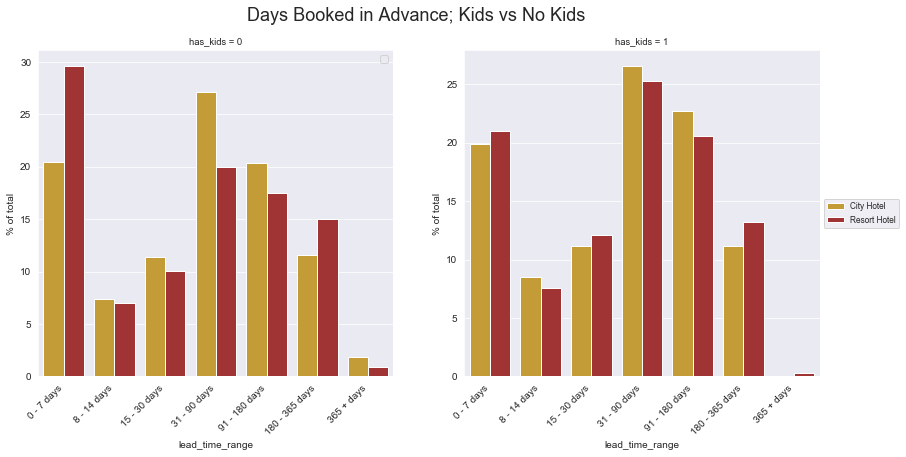

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])
g1 = sns.barplot(data = hotel_df_nc_pct[hotel_df_nc_pct['has_kids'] == 0], x = 'lead_time_range', y = '% of total',
                 hue = 'hotel', palette = fsu_colors, hue_order = hue_order, ax = ax1)
g2 = sns.barplot(data = hotel_df_nc_pct[hotel_df_nc_pct['has_kids'] == 1], x = 'lead_time_range', y = '% of total',
                 hue = 'hotel', palette = fsu_colors, hue_order = hue_order, ax = ax2)

g1.set_title('has_kids = 0', fontsize=9.5)
g2.set_title('has_kids = 1', fontsize=9.5)
g1.set_xticklabels(labels = ['0 - 7 days','8 - 14 days','15 - 30 days','31 - 90 days','91 - 180 days','180 - 365 days','365 + days'],
                   rotation=45, horizontalalignment='right')
g2.set_xticklabels(labels = ['0 - 7 days','8 - 14 days','15 - 30 days','31 - 90 days','91 - 180 days','180 - 365 days','365 + days'],
                   rotation=45, horizontalalignment='right')

g1.legend('')
leg = g2.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Days Booked in Advance; Kids vs No Kids', fontsize=18)

Note that each percentage is grouped by hotel type and whether or not the guest brought kids. So, in each chart, both the garnet and gold bars add up to 100% individually.

So, what does this tell us? Overall, it looks like the distribution of days booked in advance is similar among guests that didn't bring kids and guests that did. There does seem to be a slight difference with guests at the resort hotel. There is about a 10% decrease in guests that booked in the last week if they brought kids, while the guests that booked 31 days or more ahead of time saw slight increases of ~5%.

In [24]:
hotel_df_nc_pct = hotel_df_nc.groupby(['hotel','total_stay','has_kids'])['is_canceled'].size()
hotel_df_nc_pct = hotel_df_nc_pct.groupby(level = [0,2]).apply(lambda x: 100 * x / float(x.sum())).reset_index(name = '% of total')

Text(0.5, 0.98, 'Total Length of Stay; Kids vs No Kids')

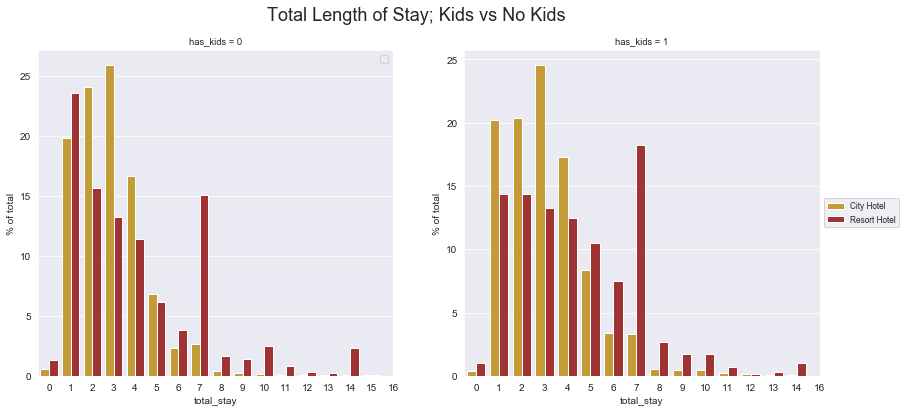

In [25]:
# Total stay length (hotel & kids group)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])
g1 = sns.barplot(data = hotel_df_nc_pct[hotel_df_nc_pct['has_kids'] == 0], x = 'total_stay', y = '% of total',
                 hue = 'hotel', palette = fsu_colors, hue_order = hue_order, ax = ax1)
g2 = sns.barplot(data = hotel_df_nc_pct[hotel_df_nc_pct['has_kids'] == 1], x = 'total_stay', y = '% of total',
                 hue = 'hotel', palette = fsu_colors, hue_order = hue_order, ax = ax2)

g1.set_title('has_kids = 0', fontsize=9.5)
g2.set_title('has_kids = 1', fontsize=9.5)
g1.set_xlim(right = 16)
g2.set_xlim(right = 15)

g1.legend('')
leg = g2.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Total Length of Stay; Kids vs No Kids', fontsize=18)

Overall it seems that the distributions are similar. We do see a slight difference again in the Resort Hotel distributions, with about a 10% drop in guests with kids who stay only 1 night. Again there wasn't quite the difference that I thought there might be between guests with/without kids.

#### Cancellations: Who, How Many, Any Trends?
Let's take a deeper dive into the variable we are going to try to predict, is_canceled.

In [26]:
tc_count = hotel_df['is_canceled'].sum()
tc_pct = tc_count/(len(hotel_df['is_canceled']))
rhc_count = hotel_df[hotel_df['hotel'] == 'Resort Hotel']['is_canceled'].sum()
rhc_pct = rhc_count/(len(hotel_df[hotel_df['hotel'] == 'Resort Hotel']['is_canceled']))
chc_count = hotel_df[hotel_df['hotel'] == 'City Hotel']['is_canceled'].sum()
chc_pct = chc_count/(len(hotel_df[hotel_df['hotel'] == 'City Hotel']['is_canceled']))
df_cancels = pd.DataFrame([['Resort',rhc_count,rhc_pct],['City',chc_count,chc_pct],['Total',tc_count,tc_pct]],
                          columns=['Group','Count','Percent'])
df_cancels

,Group,Count,Percent
0,Resort,11120,0.277681
1,City,33079,0.417859
2,Total,44199,0.370769


Text(0.5, 1.0, 'Cancels by Hotel Type')

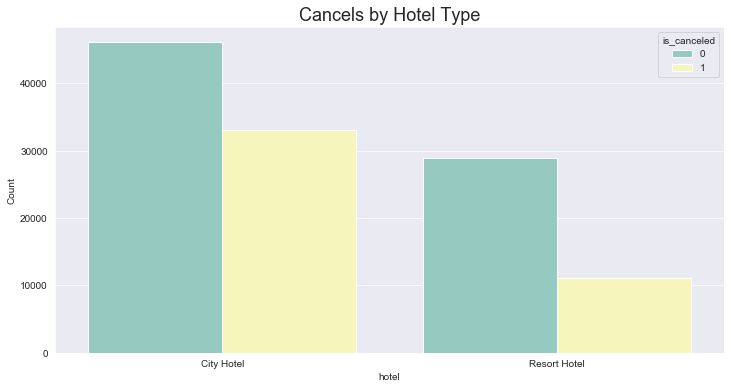

In [27]:
hotel_df_cancel = hotel_df.groupby(['hotel','is_canceled'])['lead_time'].count().reset_index(name='Count')

plt.figure(figsize=(12,6))
sns.barplot(data = hotel_df_cancel, x = 'hotel', y = 'Count', hue = 'is_canceled', palette='Set3')
plt.title('Cancels by Hotel Type', fontsize = 18)

We see that there is a much higher percentage of cancellations at the City Hotel than the Resort Hotel. Overall, there is a cancellation rate of 37%.

Let's look to see if there are any trends relating to the month of the year.

Text(0.5, 1.0, 'Cancellations by Month')

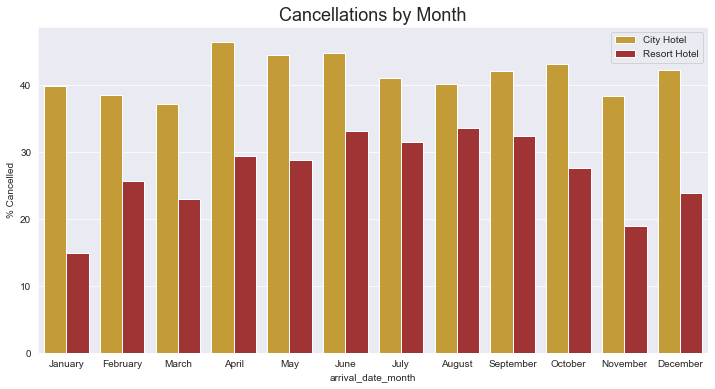

In [28]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
hotel_df_cancel_pct = hotel_df.groupby(['hotel','is_canceled','arrival_date_month'])['lead_time'].size()
hotel_df_cancel_pct = hotel_df_cancel_pct.groupby(level = [0,2]).apply(lambda x: 100 * x / float(x.sum())).reset_index(name = '% Cancelled')

plt.figure(figsize=(12,6))
g = sns.barplot(x='arrival_date_month', y='% Cancelled', data=hotel_df_cancel_pct[hotel_df_cancel_pct['is_canceled'] == 1],
                hue='hotel', palette=fsu_colors, hue_order=hue_order, order = month_order)
g.legend(loc='upper right')
plt.title('Cancellations by Month', fontsize = 18)

Cancellations at the City Hotel seem to be uniformly distributed around the average of 42%. There looks to be some seasonality with the cancellations at the Resort Hotel, rising in the summer months and falling in the winter months.

## Predictions
Now that we have analyzed the label we are trying to predict, let's begin to create some models. I will be creating 3 models and comparing the results. The models will be a Logistic Regression, a Random Forest, and a Decision Tree model.

#### Cancellations

Before we dig in to the models, let's first take a look at some correlations.

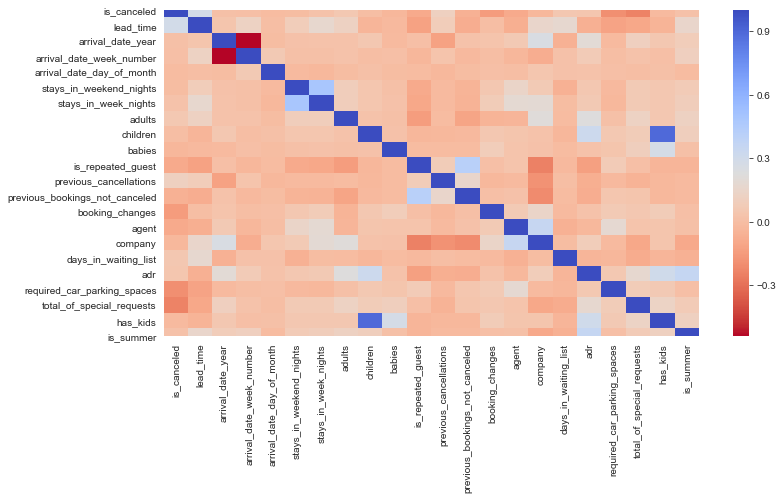

In [29]:
plt.figure(figsize=(12,6))
sns.heatmap(hotel_df.corr(), cmap = 'coolwarm_r')

In [30]:
hotel_df.corr()['is_canceled']

is_canceled                       1.000000
lead_time                         0.292883
arrival_date_year                 0.016629
arrival_date_week_number          0.008307
arrival_date_day_of_month        -0.005956
stays_in_weekend_nights          -0.001303
stays_in_week_nights              0.025555
adults                            0.058184
children                          0.004860
babies                           -0.032569
is_repeated_guest                -0.083721
previous_cancellations            0.110139
previous_bookings_not_canceled   -0.057358
booking_changes                  -0.144819
agent                            -0.083377
company                          -0.023439
days_in_waiting_list              0.054301
adr                               0.046479
required_car_parking_spaces      -0.195704
total_of_special_requests        -0.234883
has_kids                         -0.012997
is_summer                         0.023523
Name: is_canceled, dtype: float64

From this we see that lead_time, total_of_special_requests, and required_car_parking_spaces are the 3 numerical features with the most extreme correlations. I am going to exclude some of the other numerical columns because I believe that they were added after the fact (in other words after we knew that the guest canceled) and this will lead to data leakage. I will also exclude some categorical variables to keep the model as simple as possible. I will follow the format from the documentation [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [31]:
# Get everything we need for ML models
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import eli5

In [32]:
num_feats = ['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
             'stays_in_week_nights','adults', 'children', 'babies','is_repeated_guest', 'previous_cancellations',
             'previous_bookings_not_canceled','agent','company','adr','required_car_parking_spaces',
             'total_of_special_requests']
cat_feats = ['hotel','arrival_date_month','meal','market_segment','distribution_channel','reserved_room_type','deposit_type',
             'customer_type']
feats = num_feats + cat_feats

X = hotel_df.drop('is_canceled', axis = 1)[feats]
y = hotel_df['is_canceled']

num_trans = SimpleImputer(strategy='constant')
cat_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                            ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_feats),
        ('cat', cat_trans, cat_feats)])

k = 4
ksplit = KFold(n_splits=k, shuffle=True, random_state=13)

#### Model Comparison

In [33]:
cancel_model_results = []

Logistic Regression

In [34]:
lgc_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(random_state = 13))])

cross_val = cross_val_score(lgc_model, X, y, cv = ksplit, scoring='accuracy', n_jobs=-1)
cancel_model_results.append(['Log',np.mean(cross_val)])

Random Forest

In [35]:
rfc_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state = 13))])

cross_val = cross_val_score(rfc_model, X, y, cv = ksplit, scoring='accuracy', n_jobs=-1)
cancel_model_results.append(['RandomForest',np.mean(cross_val)])

Decision Tree

In [36]:
dtc_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state = 13))])

cross_val = cross_val_score(dtc_model, X, y, cv = ksplit, scoring='accuracy', n_jobs=-1)
cancel_model_results.append(['DecisionTree',np.mean(cross_val)])

In [37]:
cancel_model_results = pd.DataFrame(cancel_model_results, columns=['Model','Accuracy'])
cancel_model_results

,Model,Accuracy
0,Log,0.808605
1,RandomForest,0.857913
2,DecisionTree,0.828998


Our Random Forest model is performing the best, with an accuracy of about 86%. Let's look at which features were most important. I found [this](https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a) very helpful to get feature importance from a pipeline like we built here.

#### Feature Importance

In [38]:
rfc_model.fit(X,y)
onehot_columns = list(rfc_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_feats))
num_feats_list = list(num_feats)
num_feats_list.extend(onehot_columns)

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [39]:
eli5.formatters.as_dataframe.explain_weights_df(rfc_model.named_steps['classifier'], top=10, feature_names=num_feats_list)

,feature,weight,std
0,lead_time,0.145253,0.020463
1,deposit_type_No Deposit,0.113253,0.095995
2,adr,0.090233,0.004377
3,deposit_type_Non Refund,0.083905,0.091438
4,arrival_date_day_of_month,0.067457,0.001900
5,total_of_special_requests,0.054997,0.020419
6,arrival_date_week_number,0.050621,0.002528
7,stays_in_week_nights,0.043934,0.002566
8,agent,0.043929,0.005426
9,previous_cancellations,0.037344,0.016540


So for the Random Forest model we built to predict cancellations, the top 3 features were lead time, deposit type, and adr.

#### Special Requests

Again, let's look at some preliminary information before jumping into the models.

In [40]:
hotel_df.corr()['total_of_special_requests']

is_canceled                      -0.234883
lead_time                        -0.095944
arrival_date_year                 0.108618
arrival_date_week_number          0.026195
arrival_date_day_of_month         0.003018
stays_in_weekend_nights           0.073146
stays_in_week_nights              0.068750
adults                            0.123355
children                          0.081755
babies                            0.097939
is_repeated_guest                 0.012998
previous_cancellations           -0.048488
previous_bookings_not_canceled    0.037782
booking_changes                   0.055022
agent                             0.034382
company                          -0.098072
days_in_waiting_list             -0.082756
adr                               0.172298
required_car_parking_spaces       0.082716
total_of_special_requests         1.000000
has_kids                          0.130871
is_summer                         0.079355
Name: total_of_special_requests, dtype: float64

Instead of modeling the total number of special requests, I am going to model if the guests will require ANY special requests.

In [41]:
hotel_df['any_requests'] = [1 if x > 0 else 0 for x in hotel_df['total_of_special_requests']]

We see that we have less correlation here than we do for the is_canceled variable. Excluding the is_canceled variable for data leakage, our top 3 features are adr, adults, and has_kids. Since I will use the has_kids variable, I will exclude the children and babies variables from these models.

In [42]:
num_feats = ['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
             'stays_in_week_nights','adults', 'has_kids','is_repeated_guest', 'previous_cancellations',
             'previous_bookings_not_canceled','agent','company','adr','required_car_parking_spaces']
cat_feats = ['hotel','arrival_date_month','meal','market_segment','distribution_channel','reserved_room_type','deposit_type',
             'customer_type']
feats = num_feats + cat_feats

X1 = hotel_df.drop('any_requests', axis = 1)[feats]
y1 = hotel_df['any_requests']

num_trans = SimpleImputer(strategy='constant')
cat_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                            ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_feats),
        ('cat', cat_trans, cat_feats)])

k = 4
ksplit = KFold(n_splits=k, shuffle=True, random_state=13)

#### Model Comparison

In [43]:
request_model_results = []

Logistic Regression

In [44]:
lgr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(random_state = 13))])

cross_val = cross_val_score(lgr_model, X1, y1, cv = ksplit, scoring='accuracy', n_jobs=-1)
request_model_results.append(['Log',np.mean(cross_val)])

Random Forest

In [45]:
rfr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state = 13))])

cross_val = cross_val_score(rfr_model, X1, y1, cv = ksplit, scoring='accuracy', n_jobs=-1)
request_model_results.append(['RandomForest',np.mean(cross_val)])

Decision Tree

In [46]:
dtr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state = 13))])

cross_val = cross_val_score(dtr_model, X1, y1, cv = ksplit, scoring='accuracy', n_jobs=-1)
request_model_results.append(['DecisionTree',np.mean(cross_val)])

In [47]:
request_model_results = pd.DataFrame(request_model_results, columns=['Model','Accuracy'])
request_model_results

,Model,Accuracy
0,Log,0.719610
1,RandomForest,0.792339
2,DecisionTree,0.768063


Our Random Forest model is yet again the best performing model, but this time it is less accurate at 79%. And now for the feature importances.

#### Feature Importance

In [48]:
rfr_model.fit(X1,y1)
onehot_columns = list(rfr_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_feats))
num_feats_list = list(num_feats)
num_feats_list.extend(onehot_columns)

C:\Users\tficarro\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [49]:
eli5.formatters.as_dataframe.explain_weights_df(rfr_model.named_steps['classifier'], top=10, feature_names=num_feats_list)

,feature,weight,std
0,lead_time,0.150596,0.003979
1,adr,0.115295,0.003206
2,market_segment_Online TA,0.101260,0.072193
3,arrival_date_day_of_month,0.093652,0.002180
4,arrival_date_week_number,0.062682,0.003911
5,agent,0.058542,0.015454
6,stays_in_week_nights,0.057947,0.001596
7,market_segment_Groups,0.041740,0.041367
8,stays_in_weekend_nights,0.036084,0.001953
9,deposit_type_Non Refund,0.025347,0.039519


And for our Random Forest model to predict guests with special requests, the top 3 features were lead_time, adr, and market segment.

Thank you for reading and listening! I am always trying to become a better data scientist, so feel free to contact me with any feedback that you might have.